<a href="https://colab.research.google.com/github/DezinTI/Data-Science/blob/main/TrabPY_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📘 Explicação da Lógica do Trabalho
Este trabalho tem como objetivo avaliar a saída de um modelo de classificação binária com base na probabilidade da classe positiva. A proposta é criar um gráfico que represente a distribuição populacional por faixas de probabilidade, permitindo a definição de pontos de corte para tomada de decisão.
🔍 Etapas do processo:
- Simulação de dados
Geramos uma base genérica com probabilidades (prob_pos) e rótulos reais (target) para simular a saída de um modelo binário.
- Distribuição por faixas
Dividimos os dados em faixas de probabilidade (ex: 0–10%, 10–20%, etc.) usando um step customizável. Calculamos o percentual populacional em cada faixa.
- Visualização com histogramas
Criamos um gráfico com barras azuis para a população geral e vermelhas para os casos positivos, lado a lado, facilitando a leitura visual.
- Definição dos pontos de corte
Estabelecemos dois limites:
- Abaixo do corte inferior → classificado como negativo
- Acima do corte superior → classificado como positivo
- Entre os cortes → enviado para análise manual
- Avaliação do modelo
Calculamos métricas como acurácia, recall e precisão para entender os erros e justificar os cortes. O objetivo é minimizar a perda de casos positivos e evitar falsos negativos.



# Importando as bibliotecas:

In [32]:
# 1) Importações e configuração inicial
# Importando as bibliotecas necessárias

import pandas as pd   # Biblioteca Pandas, usada para manipulação de tabelas e DataFrames
import numpy as np    # Biblioteca NumPy, usada para cálculos matemáticos, vetores e geração de dados aleatórios
import matplotlib.pyplot as plt  # Biblioteca Matplotlib, usada para criar gráficos customizados
import seaborn as sns  # Biblioteca Seaborn, baseada no Matplotlib, facilita a criação de gráficos estatísticos

# Abaixo estão as bibliotecas do Scikit-Learn (sklearn), muito usadas em Machine Learning:

from sklearn.model_selection import train_test_split, GridSearchCV
# train_test_split  separa a base em dados de treino e teste
# GridSearchCV  faz busca de hiperparâmetros (testa várias combinações e escolhe a melhor)

from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizer  transforma textos em números

from sklearn.linear_model import LogisticRegression
# LogisticRegression  modelo estatístico simples e eficiente para classificação binária

from sklearn.ensemble import RandomForestClassifier
# RandomForestClassifier  modelo mais robusto, baseado em árvores de decisão, usado para classificação

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
# accuracy_score  mede a acurácia (taxa de acertos)
# precision_score  mede a precisão (quando digo que é positivo, quantos realmente são?)
# recall_score  mede o recall (dos positivos reais, quantos acertei?)
# f1_score  média harmônica entre precisão e recall (bom para bases desbalanceadas)
# roc_auc_score  mede a área sob a curva ROC (avalia separação entre classes)
# average_precision_score  mede a área sob a curva PR (bom quando classes estão desbalanceadas)
# roc_curve  gera pontos da curva ROC
# precision_recall_curve  gera pontos da curva Precisão-Recall

# Configuração visual padrão do Seaborn (fundo branco com grid)
sns.set(style="whitegrid")


#Criando os dados "random"

In [23]:
# Utilizando a biblioteca "NUMPY", para gerar dados random

np.random.rand(1000)  # sem seed  resultados diferentes a cada execução

# ou com seed

# np.random.seed(123) resultados iguais a cada execução

df= pd.DataFrame({
    'prob_pos': np.random.rand(1000), #probabilidade positiva

    'target' : np.random.choice([0,1], size=1000, p=[0.7, 0.3]) # retorno Real
})

df.head()

,prob_pos,target
0,0.593217,0
1,0.304188,1
2,0.001730,1
3,0.753044,0
4,0.127895,0


#Configurando a planilha

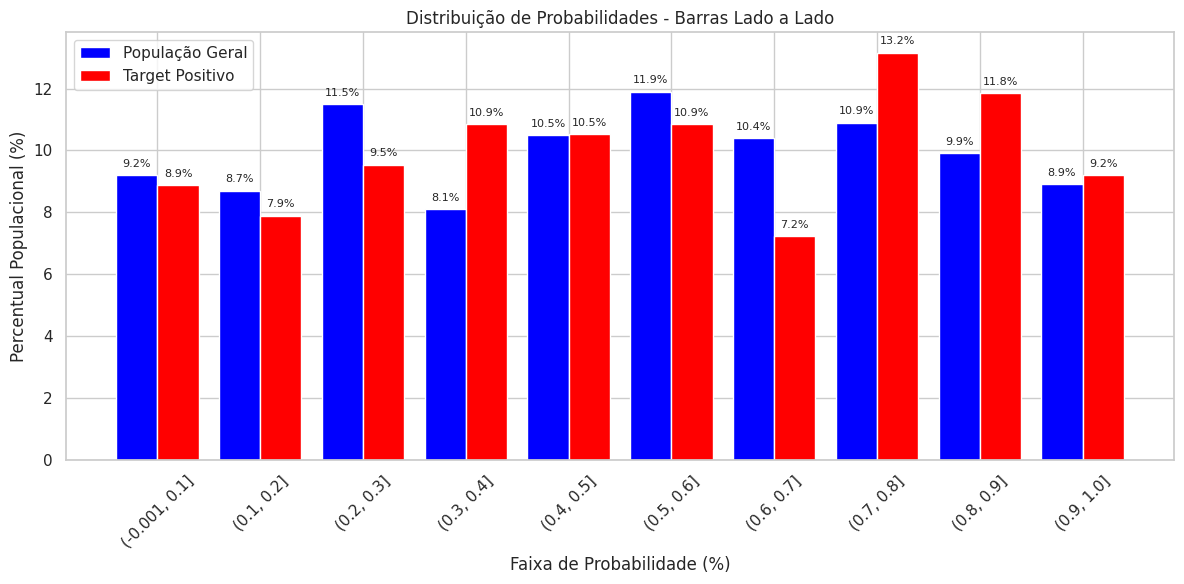

In [24]:
# Definindo o step
step = 0.1
bins = np.arange(0, 1 + step, step)
df['bin'] = pd.cut(df['prob_pos'], bins=bins, include_lowest=True)

# Calculando os percentuais
pop_total = df['bin'].value_counts(normalize=True).sort_index() * 100
pop_pos = df[df['target'] == 1]['bin'].value_counts(normalize=True).sort_index() * 100

# Garantindo que os índices estejam alinhados
labels = pop_total.index.astype(str)
x = np.arange(len(labels))
width = 0.4

# Plotando gráfico com valores
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width/2, pop_total.values, width=width, color='blue', label='População Geral')
bars2 = plt.bar(x + width/2, pop_pos.values, width=width, color='red', label='Target Positivo')

# Adicionando os valores em cima das barras
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

plt.xticks(x, labels, rotation=45)
plt.xlabel('Faixa de Probabilidade (%)')
plt.ylabel('Percentual Populacional (%)')
plt.title('Distribuição de Probabilidades - Barras Lado a Lado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Definição dos Pontos de cortes

In [25]:
# Definindo os pontos de corte
corte_neg = 0.5
corte_pos = 0.9

# Criando coluna de predição baseada nos cortes
def classificar(prob):
    if prob <= corte_neg:
        return 0 #classe negativa  força a retornar negativo
    elif prob >= corte_pos:
        return 1 #classe positiva  força a retornar positivo
    else:
        return -1  # análise manual

df['pred'] = df['prob_pos'].apply(classificar)

# Calculando métricas
total = len(df)
acertos = (df['pred'] == df['target']).sum()
acuracia = acertos / total

# Apenas onde houve decisão (sem análise manual)
df_decidido = df[df['pred'] != -1]
acuracia_decidida = (df_decidido['pred'] == df_decidido['target']).mean()

# Recall e precisão para classe positiva
verdadeiros_positivos = ((df['pred'] == 1) & (df['target'] == 1)).sum()
falsos_negativos = ((df['pred'] == 0) & (df['target'] == 1)).sum()
falsos_positivos = ((df['pred'] == 1) & (df['target'] == 0)).sum()

recall = verdadeiros_positivos / (verdadeiros_positivos + falsos_negativos)
precision = verdadeiros_positivos / (verdadeiros_positivos + falsos_positivos)

# Exibindo os resultados
print(f"Acurácia geral: {acuracia:.2f}")
print(f"Acurácia onde houve decisão: {acuracia_decidida:.2f}")
print(f"Recall (sensibilidade): {recall:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Casos enviados para análise manual: {(df['pred'] == -1).sum()} de {total}")

Acurácia geral: 0.36
Acurácia onde houve decisão: 0.64
Recall (sensibilidade): 0.16
Precisão: 0.31
Casos enviados para análise manual: 431 de 1000


#Função avaliar_cortes

In [75]:
df_cortes = pd.DataFrame({
    "prob_pos": y_prob,   # probabilidades de classe 1 do modelo
    "target": y_test.values
})


def avaliar_cortes(df, corte_neg=0.3, corte_pos=0.7):
    # Aplica os cortes
    def classificar(prob):
        if prob <= corte_neg:
            return 0
        elif prob >= corte_pos:
            return 1
        else:
            return -1  # análise manual

    df['pred'] = df['prob_pos'].apply(classificar)

    # Métricas gerais
    total = len(df)
    acertos = (df['pred'] == df['target']).sum()
    acuracia = acertos / total

    # Métricas só onde houve decisão
    df_decidido = df[df['pred'] != -1]
    acuracia_decidida = (df_decidido['pred'] == df_decidido['target']).mean()

    vp = ((df_decidido['pred'] == 1) & (df_decidido['target'] == 1)).sum()
    fn = ((df_decidido['pred'] == 0) & (df_decidido['target'] == 1)).sum()
    fp = ((df_decidido['pred'] == 1) & (df_decidido['target'] == 0)).sum()

    recall = vp / (vp + fn) if (vp + fn) > 0 else 0
    precisao = vp / (vp + fp) if (vp + fp) > 0 else 0
    analise_manual = (df['pred'] == -1).sum()

    # Exibe resultados
    print(f"🔹 Corte Negativo: {corte_neg:.2f} | Corte Positivo: {corte_pos:.2f}")
    print(f"Acurácia geral: {acuracia:.2f}")
    print(f"Acurácia onde houve decisão: {acuracia_decidida:.2f}")
    print(f"Recall (sensibilidade): {recall:.2f}")
    print(f"Precisão: {precisao:.2f}")
    print(f"Casos enviados para análise manual: {analise_manual} de {total}")


#Testando vários pontos de corte:



In [76]:
# Testando vários pontos de corte
for corte_neg in [0.3, 0.4, 0.5]:
    for corte_pos in [0.7, 0.8, 0.9]:
        avaliar_cortes(df, corte_neg=corte_neg, corte_pos=corte_pos)
        print("-" * 50)

KeyError: 'prob_pos'

#Escolhas do ponto de corte

Escolha Final do ponto de corte, analisar os resultados a cima, e escolher a melhor métrica

In [28]:
# Escolha final dos pontos de corte
corte_neg_final = 0.5
corte_pos_final = 0.8

avaliar_cortes(df, corte_neg=corte_neg_final, corte_pos=corte_pos_final)

print("\n📌 Justificativa da escolha dos cortes:")
print(f"- Corte negativo <= {corte_neg_final}: reduz falsos positivos, mantendo boa acurácia.")
print(f"- Corte positivo >= {corte_pos_final}: aumenta a confiança dos positivos, equilibrando precisão e recall.")
print("- A faixa intermediária é enviada para análise manual, representando um trade-off entre risco de erro e custo de revisão.")
print("- Essa escolha foi feita considerando o acúmulo populacional nos bins e as métricas de erro obtidas.")


🔹 Corte Negativo: 0.50 | Corte Positivo: 0.80
Acurácia geral: 0.40
Acurácia onde houve decisão: 0.60
Recall (sensibilidade): 0.31
Precisão: 0.34
Casos enviados para análise manual: 332 de 1000

📌 Justificativa da escolha dos cortes:
- Corte negativo <= 0.5: reduz falsos positivos, mantendo boa acurácia.
- Corte positivo >= 0.8: aumenta a confiança dos positivos, equilibrando precisão e recall.
- A faixa intermediária é enviada para análise manual, representando um trade-off entre risco de erro e custo de revisão.
- Essa escolha foi feita considerando o acúmulo populacional nos bins e as métricas de erro obtidas.


#Carregar Dados

Preencher com diretório na linha
dados = { "dados" }

In [58]:
from google.colab import files #Função para importar arquivos do computador

uploaded = files.upload()

# Depois de importar, você consegue ler o CSV
import pandas as pd
df = pd.read_csv("teste.csv")
print(df.head())



Saving convertcsv.csv to convertcsv (1).csv
   feature1  feature2 feature3  target
0       0.5         3        A       0
1       1.2         7        B       1
2      -0.3         2        A       0
3       0.8         9        B       1
4      -1.1         4        A       0


#Verificar Balanceamento Percentual da Base

Distribuição da classe alvo:
target
0    51.0
1    49.0
Name: proportion, dtype: float64


/tmp/ipython-input-223928827.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="target", palette="Set2")


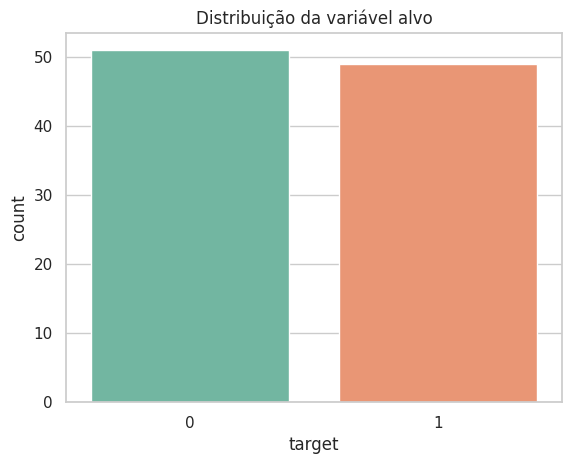

In [79]:
print("Distribuição da classe alvo:")
print(df["target"].value_counts(normalize=True) * 100)
sns.countplot(data=df, x="target", palette="Set2")
plt.title("Distribuição da variável alvo")
plt.show()

#Pré Processamento / Extração de caracteristicas

Sempre revisar nome das colunas .CSV, para não haver erros, utilize print(df.columns) “célula abaixo”

In [65]:
print(df.columns)

Index(['seq', 'name/first', 'name/last', 'age', 'street', 'city', 'state',
       'zip', 'dollar', 'pick', 'date'],
      dtype='object')


Função para treinar, e testar o csv

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# -----------------------------
# 1️⃣ Carregar CSV
# -----------------------------
df = pd.read_csv("convertcsv.csv")  # alterar conforme uso

# -----------------------------
# 2️⃣ Detectar coluna de texto longo
# -----------------------------
col_text = None
for col in df.columns:
    if df[col].dtype == "object":  # tipo texto
        media_tamanho = df[col].astype(str).str.len().mean()
        if media_tamanho > 15:  # texto longo
            col_text = col
            break

# -----------------------------
# 3️⃣ Detectar/definir coluna alvo
# -----------------------------
col_target = df.columns[-1]  # pega última coluna

# Se última coluna for numérica -> ok
# Se for texto único por linha (como data), cria target binário de exemplo
if df[col_target].nunique() == len(df):
    print(f"A coluna '{col_target}' tem valores únicos. Criando target binário de exemplo.")
    # Exemplo: 1 se 'dollar' > média, 0 caso contrário
    if 'dollar' in df.columns:
        df['target'] = df['dollar'].replace('[\$,]', '', regex=True).astype(float)
        media = df['target'].mean()
        df['target'] = (df['target'] > media).astype(int)
        col_target = 'target'
    else:
        # caso não tenha 'dollar', cria target aleatório
        df['target'] = np.random.randint(0, 2, size=len(df))
        col_target = 'target'

y = df[col_target]

print("Coluna de texto detectada:", col_text)
print("Coluna alvo detectada:", col_target)

# -----------------------------
# 4️⃣ Preparar features
# -----------------------------
# Separar colunas numéricas e categóricas (excluindo alvo e texto longo)
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

if col_text and col_text in categorical_cols:
    categorical_cols.remove(col_text)
if col_target in numerical_cols:
    numerical_cols.remove(col_target)
elif col_target in categorical_cols:
    categorical_cols.remove(col_target)

# -----------------------------
# 5️⃣ Pipeline de pré-processamento
# -----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # mantém texto longo se existir
)

# Se houver texto longo, transforma com TF-IDF
if col_text:
    vectorizer = TfidfVectorizer()
    X_text = vectorizer.fit_transform(df[col_text])
    # Remove coluna de texto original do dataframe
    df_no_text = df.drop(columns=[col_text, col_target])
    X_tab = preprocessor.fit_transform(df_no_text)

    # Combina features tabulares + texto
    from scipy.sparse import hstack
    X = hstack([X_tab, X_text])
else:
    X = preprocessor.fit_transform(df.drop(columns=[col_target]))

# -----------------------------
# 6️⃣ Split treino/teste
# -----------------------------
# Tenta usar stratify se possível, senão ignora
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
except ValueError:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

print("Treino:", X_train.shape, "Teste:", X_test.shape)




A coluna 'date' tem valores únicos. Criando target binário de exemplo.
Coluna de texto detectada: None
Coluna alvo detectada: target
Treino: (70, 635) Teste: (30, 635)


<>:35: SyntaxWarning: invalid escape sequence '\$'
<>:35: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-2908098434.py:35: SyntaxWarning: invalid escape sequence '\$'
  df['target'] = df['dollar'].replace('[\$,]', '', regex=True).astype(float)


#Treinar Modelos: Regressão Logística e Random Forest

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Definir coluna alvo (última coluna do CSV)
col_target = df.columns[-1]

# Detectar colunas do tipo object (possível texto)
text_cols = df.select_dtypes(include='object').columns.tolist()
text_cols = [col for col in text_cols if col != col_target]

X_text = None

for col_text in text_cols:
    # Apenas usa se houver algum texto válido
    if df[col_text].dropna().astype(str).str.strip().str.len().sum() > 0:
        vectorizer = TfidfVectorizer()
        try:
            X_text = vectorizer.fit_transform(df[col_text])
            print(f"Coluna de texto detectada e transformada: {col_text}")
            break
        except ValueError:
            print(f"A coluna {col_text} não contém texto válido. Ignorando TF-IDF.")

# Colunas numéricas/categóricas restantes
cols_features = [c for c in df.columns if c != col_target and c not in text_cols]
X_num = pd.get_dummies(df[cols_features])

# Combinar X_text + X_num
if X_text is not None:
    X = hstack([X_text, X_num.values])
else:
    X = X_num.values

y = df[col_target]

# Separar treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Pré-processamento concluído!")
print(f"Tamanho treino: {X_train.shape[0]}, Tamanho teste: {X_test.shape[0]}")


Coluna de texto detectada e transformada: name/first
Pré-processamento concluído!
Tamanho treino: 70, Tamanho teste: 30


In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1️⃣ Regressão Logística
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("=== Regressão Logística ===")
print(classification_report(y_test, y_pred_lr))
print("Acurácia:", accuracy_score(y_test, y_pred_lr))

# 2️⃣ Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("Acurácia:", accuracy_score(y_test, y_pred_rf))


=== Regressão Logística ===
              precision    recall  f1-score   support

           0       0.38      0.33      0.36        15
           1       0.41      0.47      0.44        15

    accuracy                           0.40        30
   macro avg       0.40      0.40      0.40        30
weighted avg       0.40      0.40      0.40        30

Acurácia: 0.4

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.46      0.80      0.59        15
           1       0.25      0.07      0.11        15

    accuracy                           0.43        30
   macro avg       0.36      0.43      0.35        30
weighted avg       0.36      0.43      0.35        30

Acurácia: 0.43333333333333335


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#Avaliar Pontos de corte com progama - inserir titulo (da celular q usamos para avaliar os cortes)


In [78]:
def avaliar_cortes(y_true, y_prob, corte_neg=0.2, corte_pos=0.8):
    """
    Avalia métricas em diferentes pontos de corte:
    - Abaixo de corte_neg → classe 0 (negativa)
    - Acima de corte_pos → classe 1 (positiva)
    - Entre eles → 'manual'
    """
    y_pred = []

    for p in y_prob:
        if p < corte_neg:
            y_pred.append(0)
        elif p > corte_pos:
            y_pred.append(1)
        else:
            y_pred.append("manual")

    df_cortes = pd.DataFrame({"Prob": y_prob, "Target": y_true, "Pred": y_pred})

    # métricas sem contar os casos manuais
    df_validos = df_cortes[df_cortes["Pred"] != "manual"]
    acc = accuracy_score(df_validos["Target"], df_validos["Pred"])
    prec = precision_score(df_validos["Target"], df_validos["Pred"])
    rec = recall_score(df_validos["Target"], df_validos["Pred"])
    f1 = f1_score(df_validos["Target"], df_validos["Pred"])

    print(f"--- Avaliação com cortes neg={corte_neg}, pos={corte_pos} ---")
    print("Tamanho total:", len(df_cortes))
    print("Casos manuais:", sum(df_cortes['Pred'] == 'manual'))
    print(f"Accuracy={acc:.3f}, Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")
    print()

    return df_cortes

# Testando no melhor modelo
modelo_escolhido = rf
y_prob = modelo_escolhido.predict_proba(X_test)[:, 1]
avaliar_cortes(y_test.values, y_prob, corte_neg=0.3, corte_pos=0.7)


ValueError: Classification metrics can't handle a mix of binary and unknown targets